In [7]:
'''server setup'''
from fastai.vision.all import *
import urllib.request
# MODEL_URL: path to the export.pkl file
MODEL_URL = "https://www.dropbox.com/s/v6v57mixzqojk6j/export.pkl?dl=1"
urllib.request.urlretrieve(MODEL_URL, "model.pkl")
# p = Path('../export.pkl')

('model.pkl', <http.client.HTTPMessage at 0x7fe306d4ee10>)

In [8]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
def getY(f):
    return path_hr/f.name
def get_data(bs,size):
    dblock = DataBlock(blocks=(ImageBlock(), ImageBlock()),
                   splitter=RandomSplitter(valid_pct=.1, seed=42),
                   get_items = get_image_files, 
                   get_y = getY, 
                   item_tfms=[Resize(size)], 
                   batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(max_zoom=2.0)],
                   n_inp=1)

    dls = dblock.dataloaders(path_mr, path, verbose=True, bs=bs)
    dls.c = 3
    return dls        

In [9]:
learner = load_learner("model.pkl")

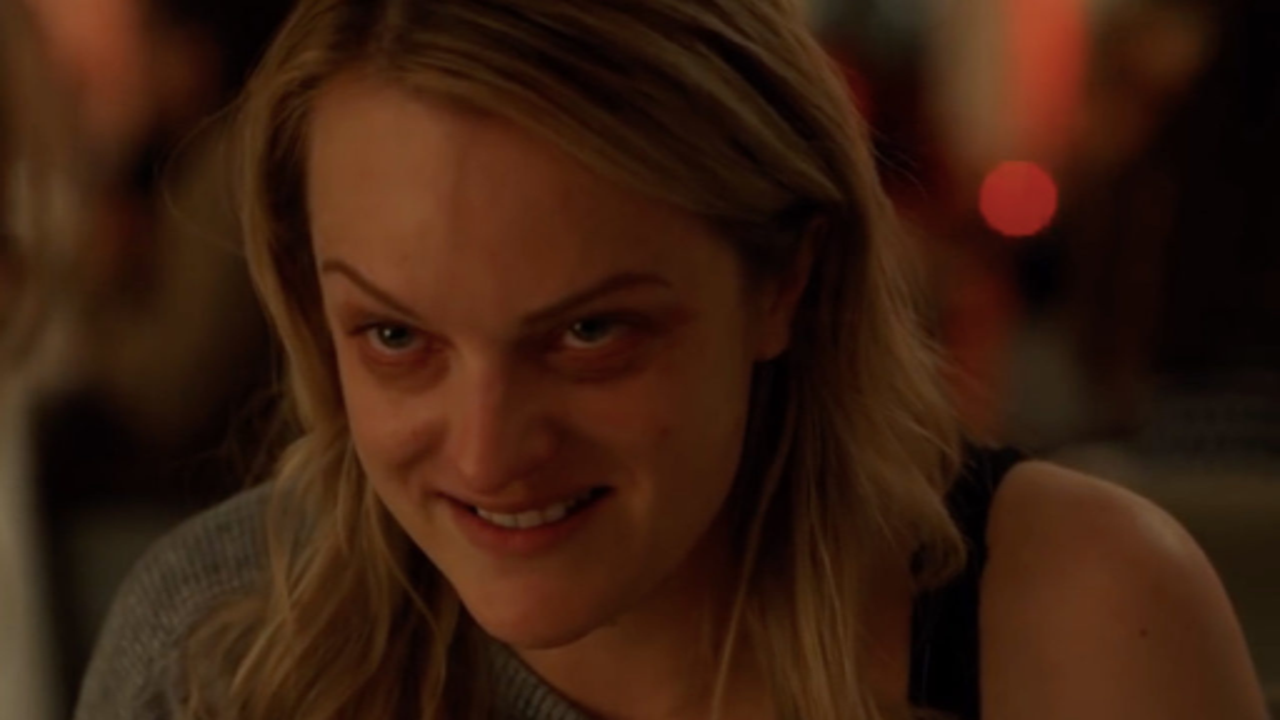

In [11]:
# inp = Path('../images_hr/00001.png')
inp = Path('./The-Invisible-Man-Screenshot-2-1280x720.jpg')
img = Image.open(inp)
img = PILImage.create(inp)
sz = img.size
img = img.resize((512,512))
img.resize(sz)

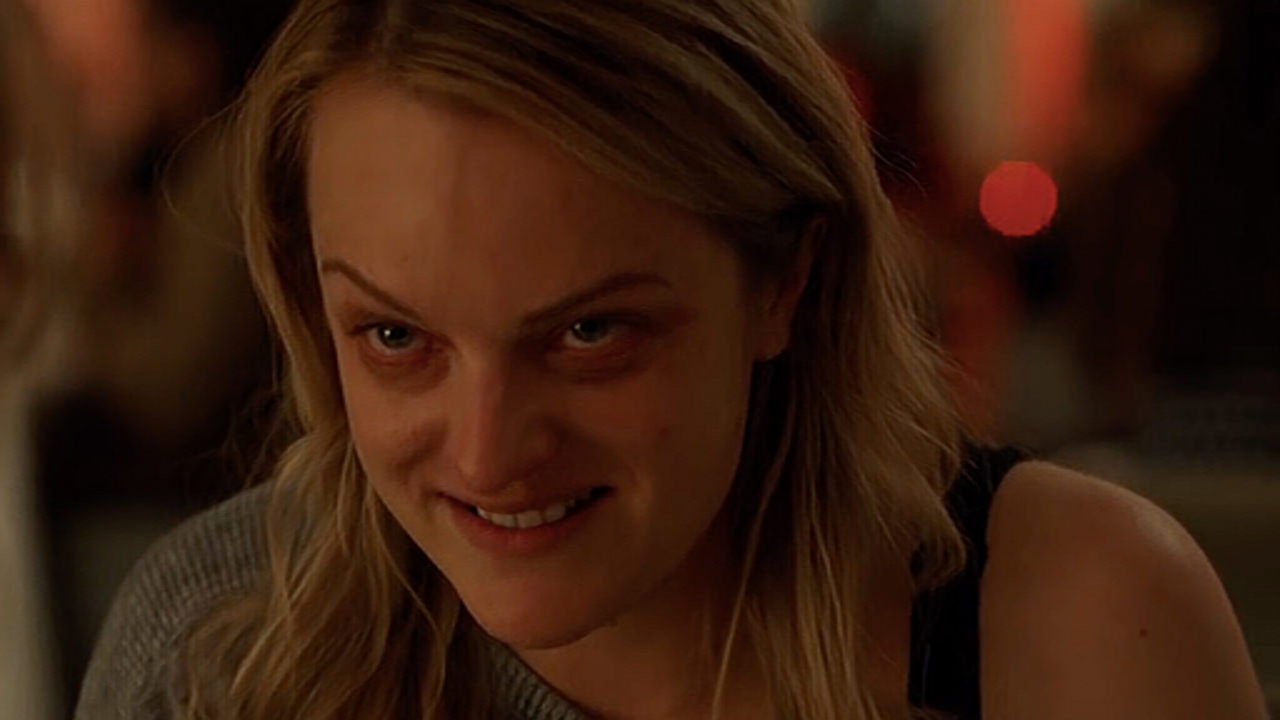

In [12]:
a, b, c = learner.predict(array(img))
PILImage.create(a).resize(sz)

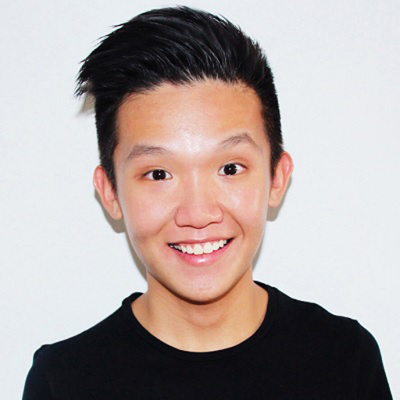

In [13]:
# inp = Path('../images_hr/00001.png')
inp = Path('./Shawn_Tok_Profile.jpg')
img = Image.open(inp)
img = PILImage.create(inp)
sz = img.size
img = img.resize((512,512))
img.resize(sz)

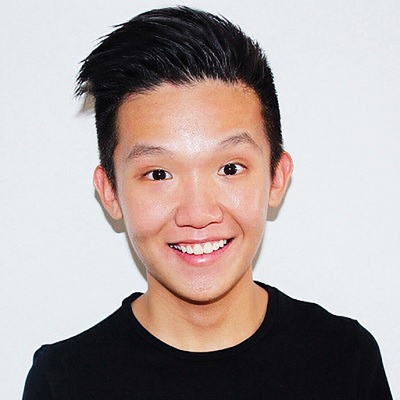

In [14]:
a, b, c = learner.predict(array(img))
PILImage.create(a).resize(sz)